2023-01-24 11:34:13,535	INFO worker.py:1538 -- Started a local Ray instance.
(RolloutWorker pid=6340) 2023-01-24 11:34:19,325	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-01-24 11:34:21,844	WARNING util.py:66 -- Install gputil for GPU system monitoring.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 hidden_1 (Dense)               (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 hidden_2 (Dense)               (None, 256)          65792       ['hidden_1[0][0]']               
                                                                                                  
 policy_out (Dense)             (None, 2)            514         ['hidden_2[0][0]']               
                                                                                              

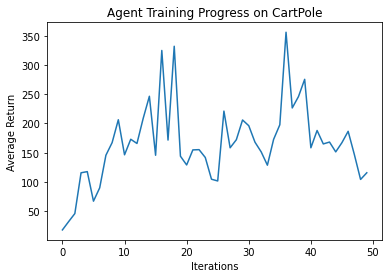

[17.8,
 32.0,
 45.8,
 115.6,
 117.6,
 67.0,
 89.8,
 145.6,
 167.2,
 206.4,
 146.4,
 173.0,
 165.8,
 208.6,
 246.6,
 145.6,
 325.0,
 171.6,
 332.2,
 144.0,
 129.0,
 154.8,
 155.2,
 141.8,
 104.6,
 101.6,
 221.2,
 158.4,
 172.2,
 206.0,
 196.2,
 168.0,
 151.4,
 128.6,
 172.8,
 197.8,
 356.2,
 226.6,
 246.0,
 275.6,
 158.4,
 188.0,
 165.0,
 168.2,
 151.4,
 167.2,
 186.6,
 146.8,
 104.2,
 115.6]

In [6]:
import random
import ray
import tensorflow as tf
import utils
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from environments.cartpole import CartPoleEnv


class PPOCustomModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        inputs = tf.keras.layers.Input(shape=obs_space.shape, name='observations')
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model(inputs, [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict["obs"])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])


ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("ppo_model", PPOCustomModel)
tf.random.set_seed(seed=0)
random.seed(0)

model_config = {
    'vf_share_layers': True,
    'custom_model': 'ppo_model',
    'custom_model_config': {}
}
agent_config = PPOConfig()
agent_config.model = model_config
agent_config.rollouts(num_rollout_workers=2, rollout_fragment_length=256)
agent_config.batch_mode = 'complete_episodes'
agent_config.use_critic = True
agent_config.use_gae = True
agent_config.clip_param = 0.3
agent_config.entropy_coeff = 0.01
agent_config.kl_coeff = 0.01
agent_config.shuffle_sequences = True
agent_config.num_sgd_iter = True
agent_config.sgd_minibatch_size = 32
agent_config.train_batch_size = 512
agent_config.seed = 0
agent_config.gamma = 0.99
agent_config.lr = 0.0005
agent_config.num_gpus = 1

agent = agent_config.environment(env=CartPoleEnv, env_config={'verbose': False}).build()
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))